In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [2]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [3]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "kmdcm_pbe0dz_FOE.ff.pkl"

In [4]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)

In [5]:
_c.intE = "epol_mike"
_c.set_targets()
# _c.targets
# _c.data.ECOL
# _c.data.ELEC

In [6]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [1440.8827986567271, 1259.357126683941, 229.13241842819056, 1211.163742639586, 77.15615270450104]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  205.14251708984375
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 205.14251708984375
             x: [ 3.357e+02  5.563e+02  2.139e+02  1.000e+02  3.346e+02]
           nit: 105
          nfev: 295
 final_simplex: (array([[ 3.357e+02,  5.563e+02, ...,  1.000e+02,
                         3.346e+02],
                       [ 3.357e+02,  5.563e+02, ...,  1.000e+02,
                         3.346e+02],
                       ...,
                       [ 3.357e+02,  5.563e+02, ...,  1.000e+02,
                         3.346e+02],
                       [ 3.357e+02,  5.563e+02, ...,  1.000e+02,
                         3.346e+02]]), array([ 2.051e+02,  2.051e+02,  2.051e+02,  2.051e+02,
                        2.051e+02,  2.051e+02]))


In [7]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([335.65528085, 556.28283933, 213.92201896, 100.        ,
       334.60470276])

In [8]:
np.sqrt(loss)

14.322797

1.9291152576751827e-167


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 205.14250208624202,
  'RMSE': 14.322796587476972,
  'R': 0.8849851204369134,
  'RS': 0.870871131484526,
  'n': 500,
  'slope': 0.9181775521957962,
  'intercept': -9.911551653011543})

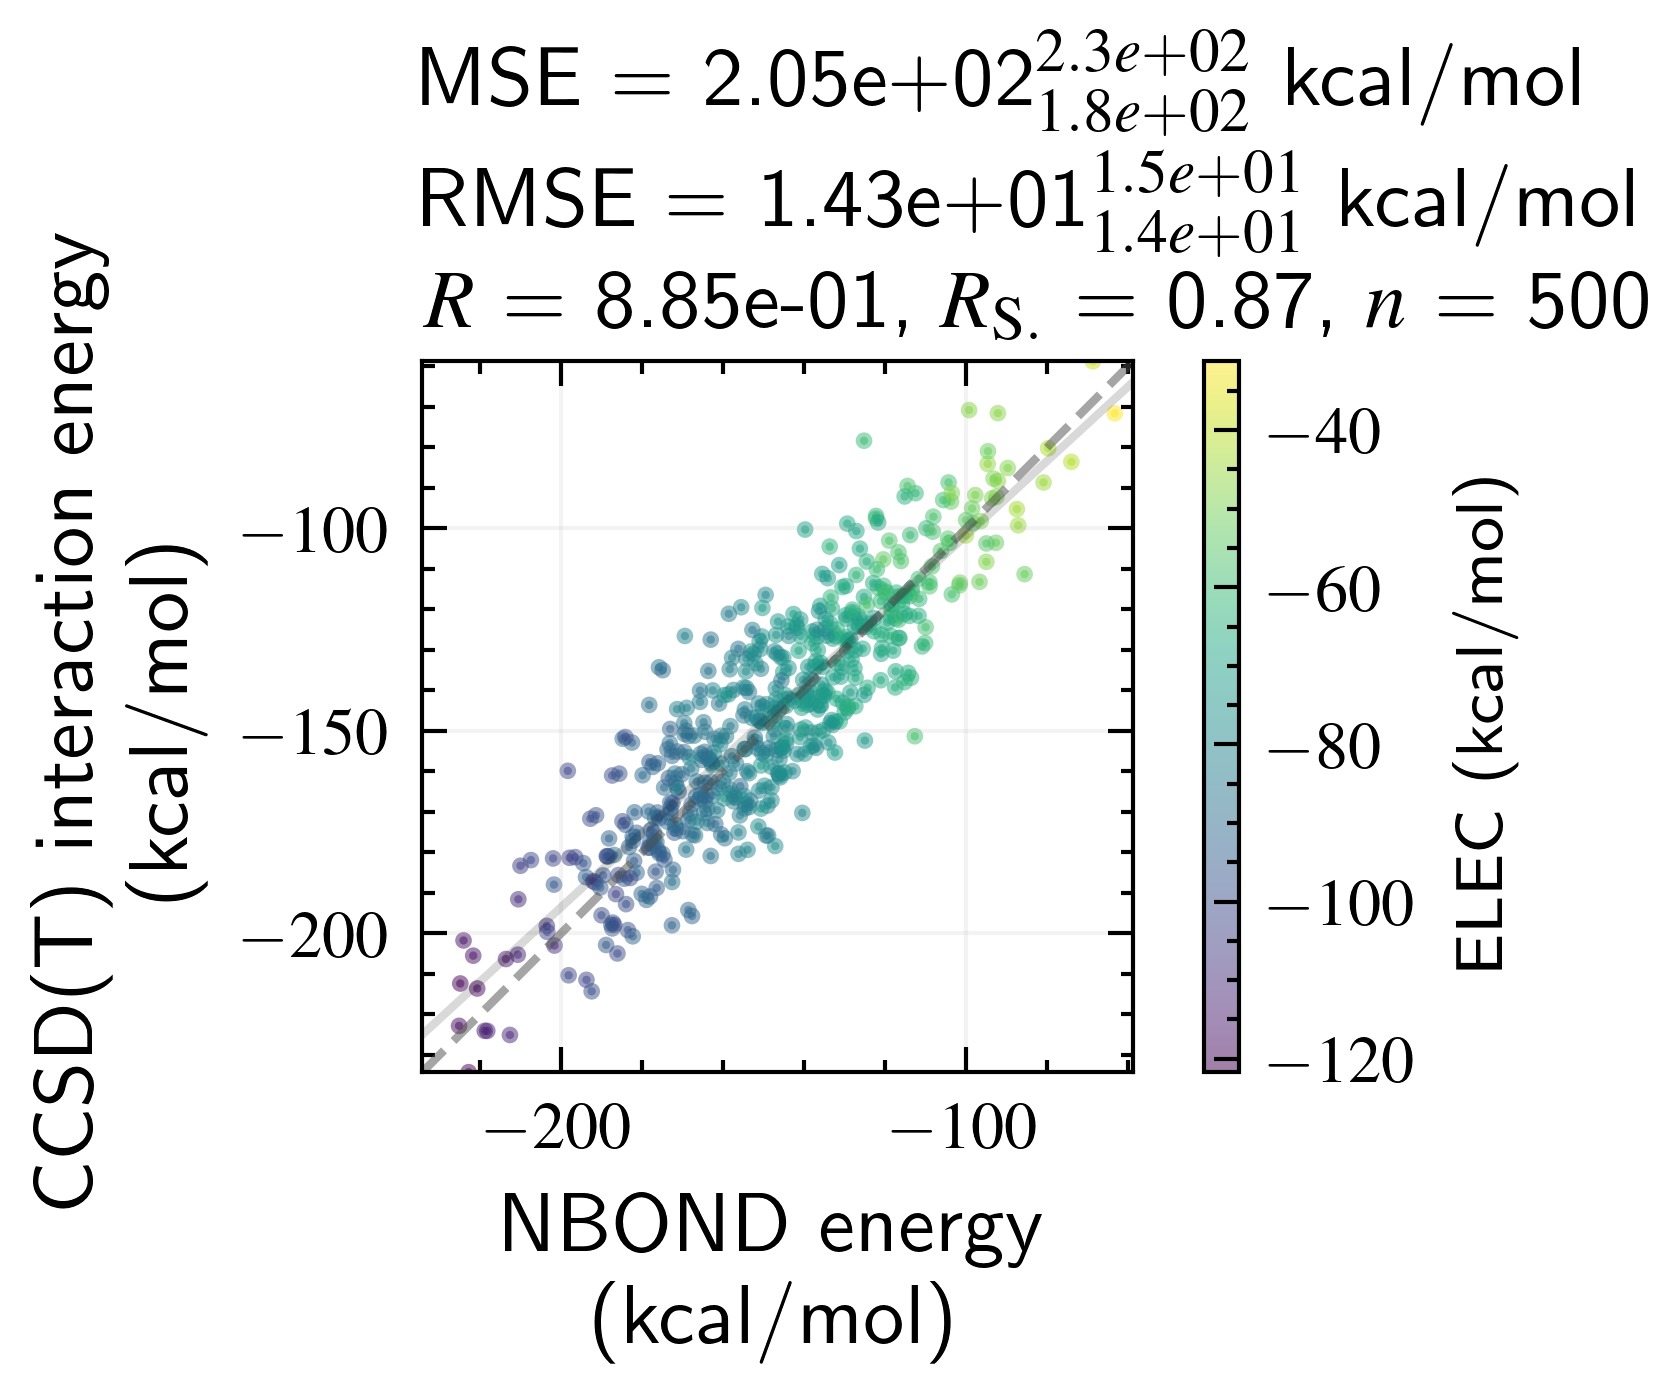

In [9]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "epol_mike", "fit_ECOL",  elec = "ELEC")


5e-323


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 5150.804354024634,
  'RMSE': 71.76910445327178,
  'R': 0.9739379944835115,
  'RS': 0.9711176124704497,
  'n': 500,
  'slope': 0.506897631251822,
  'intercept': -2.942575152703739})

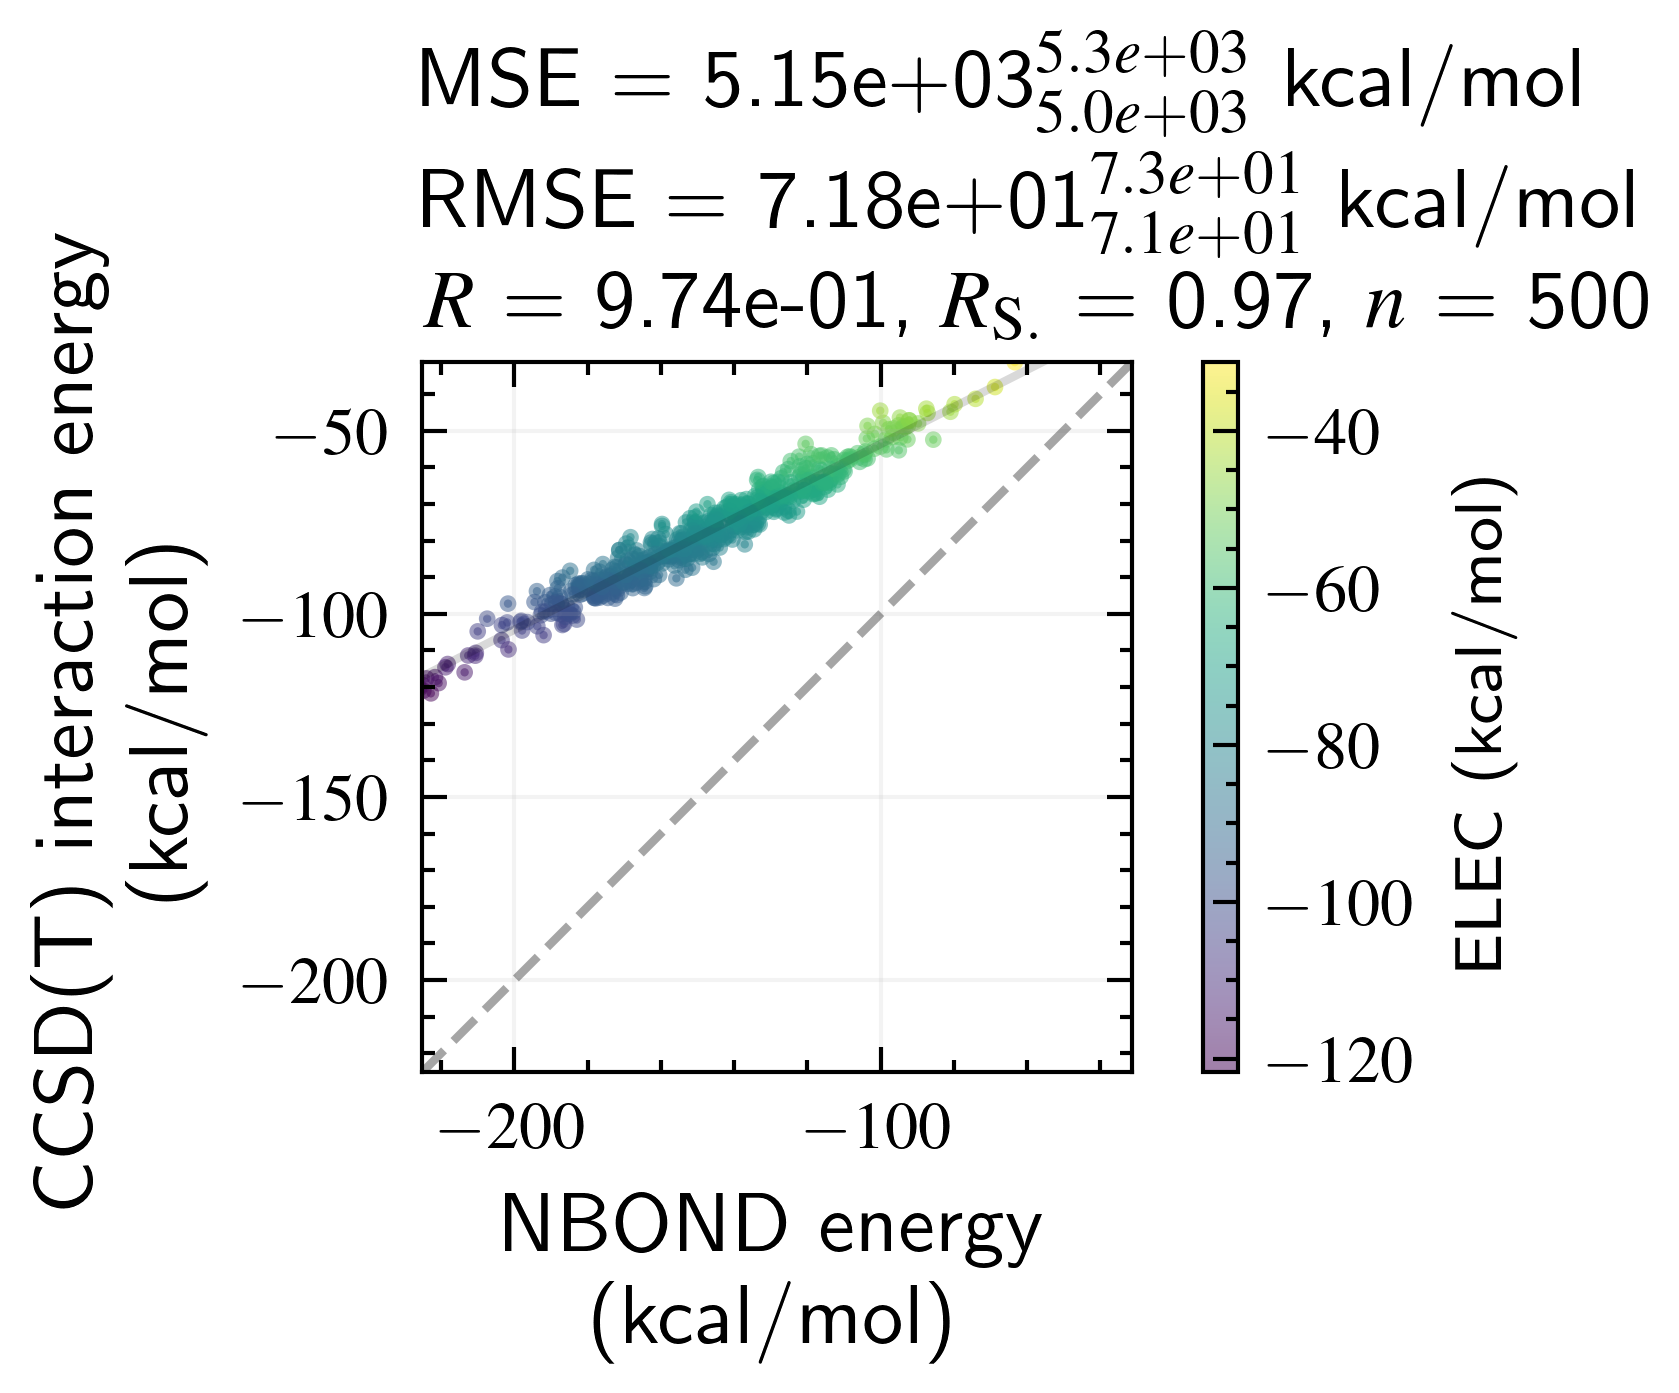

In [10]:
plot_energy_MSE(_c.data, "epol_mike", "ELEC",  elec = "ELEC")

#  LJ fit


In [14]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = _c
LJFF.elec = "fit_ECOL"
LJFF

FF: LJ water_cluster fit_ECOL harmonic first_order_energy (jax_coloumb: True)

In [15]:
# _c.targets

In [16]:
fit_repeat(LJFF, 
           3, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_jax
bounds: ((0.001, 2.5), (0.001, 2.5), (0.001, 2.5), (0.001, 2.5))
maxfev: 10000
initial guess: [1.9077160647106066, 1.5585785762102677, 0.1312347671348335, 0.8700405160613216]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  23.46345329284668
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23.46345329284668
             x: [ 1.000e-03  2.203e+00  8.401e-01  2.314e-02]
           nit: 400
          nfev: 711
 final_simplex: (array([[ 1.000e-03,  2.203e+00,  8.401e-01,  2.314e-02],
                       [ 1.000e-03,  2.203e+00,  8.401e-01,  2.314e-02],
                       ...,
                       [ 1.000e-03,  2.203e+00,  8.401e-01,  2.314e-02],
                       [ 1.000e-03,  2.203e+00,  8.401e-01,  2.314e-02]]), array([ 2.346e+01,  2.346e+01,  2.346e+01,  2.346e+01,
                        2.346e+01]))
Optimizing LJ parameters...
function: get_loss_jax
bounds: ((0.001, 2.5), (0.001, 2.5), (0.001, 2.5), (0.001, 2.5))
maxfev: 10000
initial guess: [1.1342924537042294, 0.10424589921692073, 0.5155266122407057, 2.1173779285145384]
final_loss_fn:  1662.49462890625
       message: Optimization terminated successfully.
       s

In [17]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
0,23.463453,400,711,0,True,Optimization terminated successfully.,"[0.001, 2.203358298287788, 0.8401262298526752,...","([[0.001, 2.203358298287788, 0.840126229852675..."
1,1662.494629,287,542,0,True,Optimization terminated successfully.,"[2.100376934313612, 0.13763158855742022, 0.001...","([[2.100376934313612, 0.13763158855742022, 0.0..."
2,8074.825684,64,177,0,True,Optimization terminated successfully.,"[0.013128079556992175, 0.1613921795584108, 2.5...","([[0.013128079556992175, 0.1613921795584108, 2..."


In [ ]:
LJFF.data["fit_intE"] = 


plot_energy_MSE(_c.data, "epol_mike", "ELEC",  elec = "ELEC")

#  DE fit


In [35]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = _c
DEFF.elec = "fit_ECOL"
# DEFF.targets

In [20]:
fit_repeat(DEFF, 
           2, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [29]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
2,33.393085,1223,1971,0,True,Optimization terminated successfully.,"[0.3822914637112108, 1.28280501590252, 2.49984...","([[0.3822914637112108, 1.28280501590252, 2.499..."
1,78.747047,1231,1986,0,True,Optimization terminated successfully.,"[0.9876859392680452, 0.7376234445776066, 2.035...","([[0.9876859392680452, 0.7376234445776066, 2.0..."
0,205.142517,105,295,0,True,Optimization terminated successfully.,"[335.65528084964274, 556.2828393271604, 213.92...","([[335.65528084964274, 556.2828393271604, 213...."


In [22]:
bestres = list(pd.DataFrame(\
                  _c.opt_results)\
     .sort_values("fun").x)[0]

In [32]:
DEFF.data["fit"] = DEFF.eval_jax(bestres) 
DEFF.data["target"] = DEFF.targets - DEFF.data[DEFF.elec]

3.286530727129442e-28


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 28552.691,
  'RMSE': 168.97542,
  'R': -0.46515072588725587,
  'RS': -0.4489786279145116,
  'n': 500,
  'slope': -0.7126443385150002,
  'intercept': 11.356514361739983})

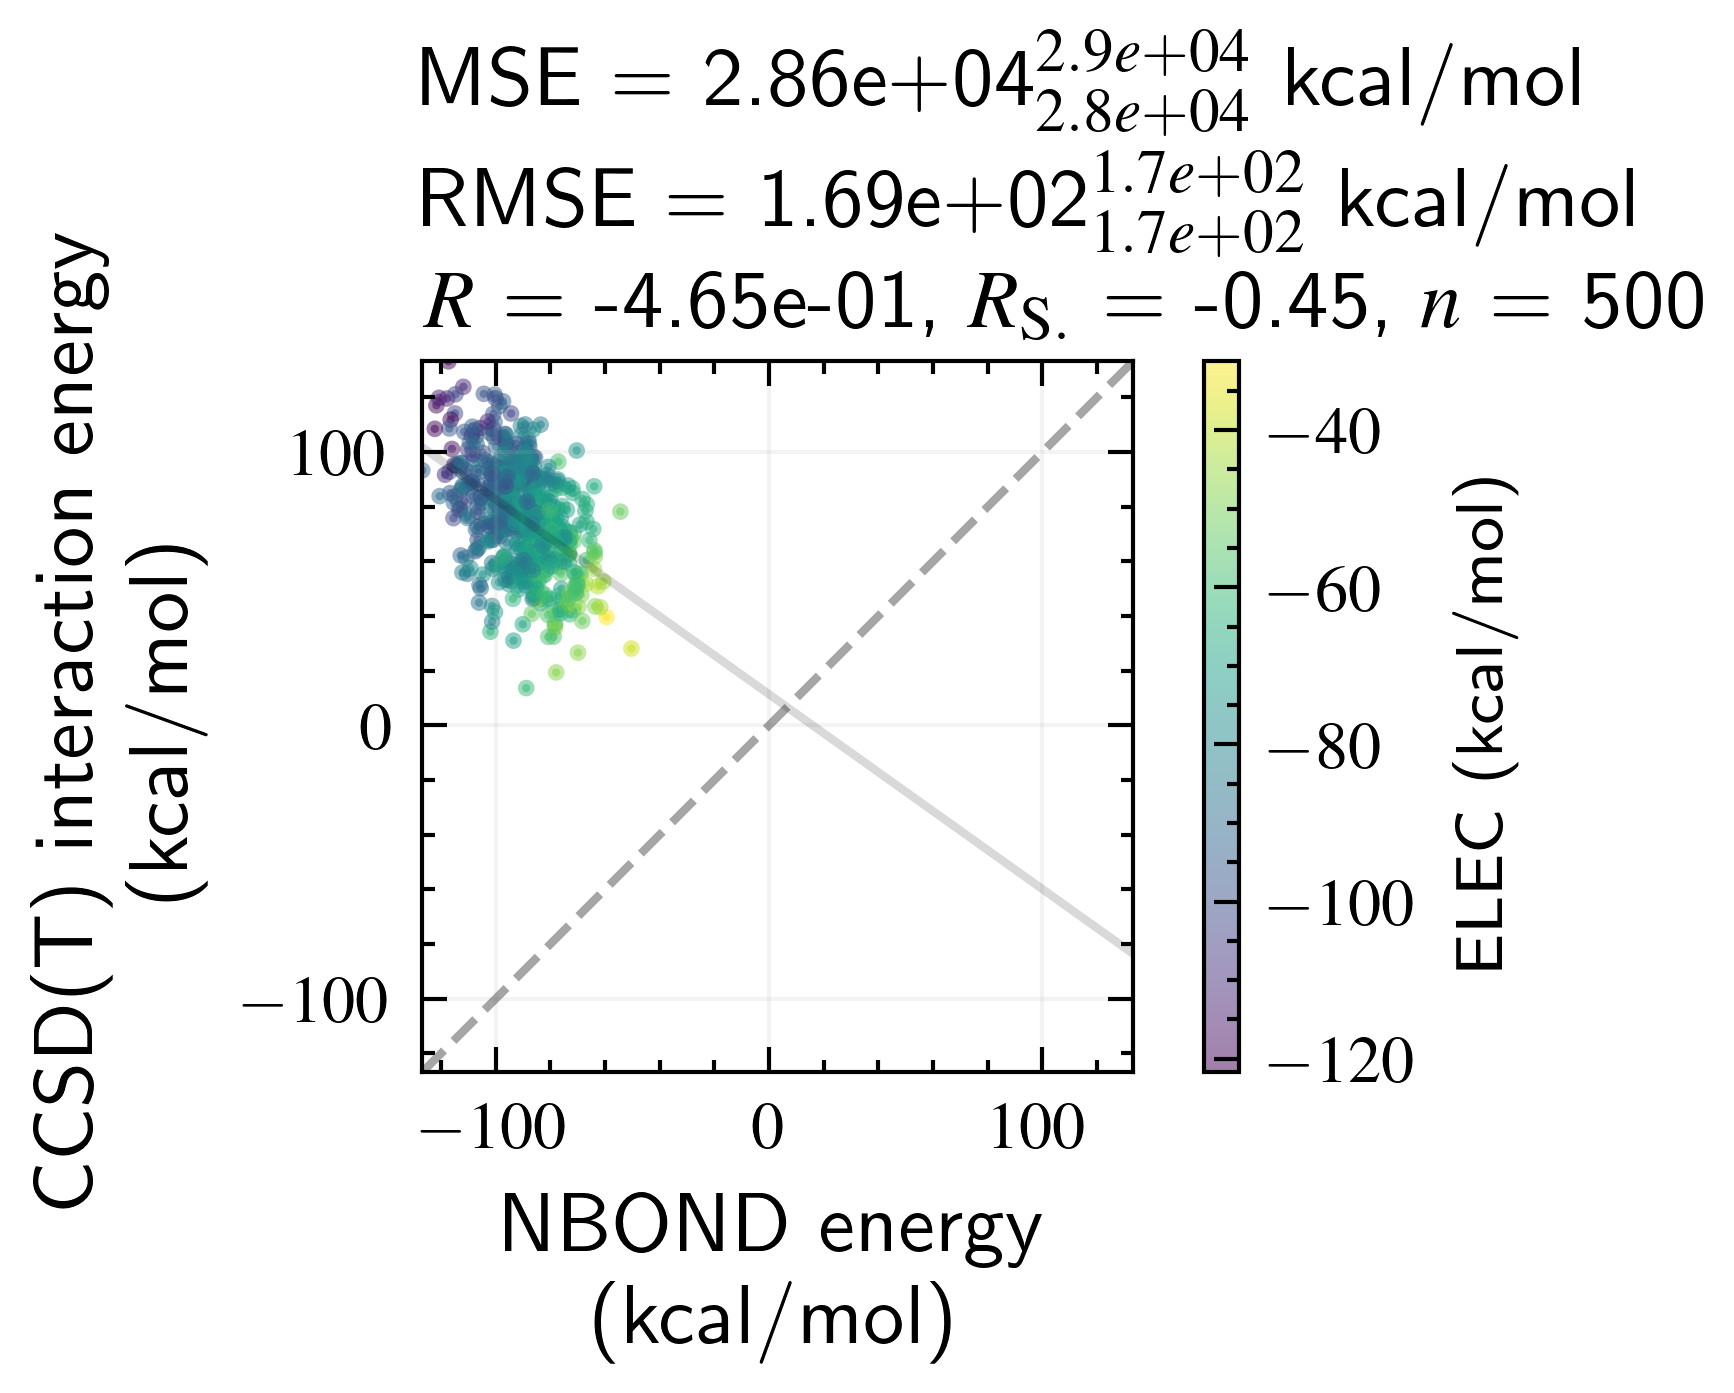

In [33]:
plot_energy_MSE(DEFF.data, "fit", 
                "target",  
                elec = "ELEC")